### INSTRUMENT AND SYSTEM SUITABILITY ANALYSIS

**Author:** Christopher Edozie Sunday  
**Data Source:** SQLite QC Database (qc_structured.db)  
**Scope:** Instrument qualification, chromatographic system suitability, and
fitness-for-use evaluation  

---

#### Abstract
This report evaluates chromatographic system suitability and instrument
capability using resolution, theoretical plates, tailing factor, retention time
stability, and peak area consistency. Trend analysis, capability indices, and
multivariate QC summaries were applied to detect degradation, verify operational
control, and support objective instrument fitness decisions.


### Experimental Context and QC Objectives

System suitability testing ensures that chromatographic systems are capable of
producing data of acceptable resolution, efficiency, symmetry, and stability
prior to and during routine analysis. Degradation in these metrics may indicate
column aging, detector instability, injector wear, or method drift.

The objectives of this analysis were to:
- Monitor resolution and tailing trends over time
- Quantify instrument capability using statistical process indices (Cpk)
- Detect abrupt efficiency changes using plate count Z-score analysis
- Summarize system suitability compliance across instruments and months
- Support data-driven instrument fitness and maintenance decisions


In [1]:
# ========================== SETUP & DATA PATH ==========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from matplotlib.dates import DateFormatter
from matplotlib.colors import ListedColormap
from datetime import datetime
import sys

plt.rcParams.update({'figure.max_open_warning': 0})

# Output directories
OUTPUT_DIR = "visuals"
FIG_DIR = f"{OUTPUT_DIR}/figures"
TABLE_DIR = f"{OUTPUT_DIR}/tables"
for d in [OUTPUT_DIR, FIG_DIR, TABLE_DIR]:
    os.makedirs(d, exist_ok=True)

# Database connection
db_path = "/Users/christopheredoziesunday/Documents/Chrom-Data-Analysis/qc_structured.db"
engine = create_engine(f"sqlite:///{db_path}")

# Load data
df = pd.read_sql(
    """
    SELECT cs.instrument_id, cs.out_of_control, cs.ucl, cs.lcl,
           s.sample_id, s.retention_time_min, s.peak_area, s.run_date, s.month,
           ss.plates, ss.resolution, ss.tailing
    FROM control_summary cs
    JOIN instruments i
        ON cs.instrument_id = i.instrument_id
    LEFT JOIN samples s
        ON cs.instrument_id = s.instrument_id
    LEFT JOIN system_suitability ss
        ON ss.sample_id = s.sample_id;
    """, con=engine)

print(f"Records loaded: {df.shape[0]}")

Records loaded: 449


### Data Integrity and Pre-Processing

System suitability metrics were validated for completeness, temporal ordering,
and instrument attribution prior to statistical evaluation. Ensuring consistent
time alignment is critical for trend and change-detection analyses.


In [2]:
df["run_date"] = pd.to_datetime(df["run_date"], errors="coerce")
df = df.dropna(subset=["instrument_id", "run_date"])
df = df.sort_values("run_date")
instrs = df["instrument_id"].unique()

print(f"Instruments evaluated: {len(instrs)}")

Instruments evaluated: 2


### Resolution Trend Analysis
Resolution trends were monitored to ensure consistent chromatographic separation
between critical peaks. A minimum acceptance threshold of Rs ≥ 1.5 was applied,
as reduced resolution compromises selectivity and quantitative reliability.
Rolling statistics aid in early detection of column degradation or method drift.


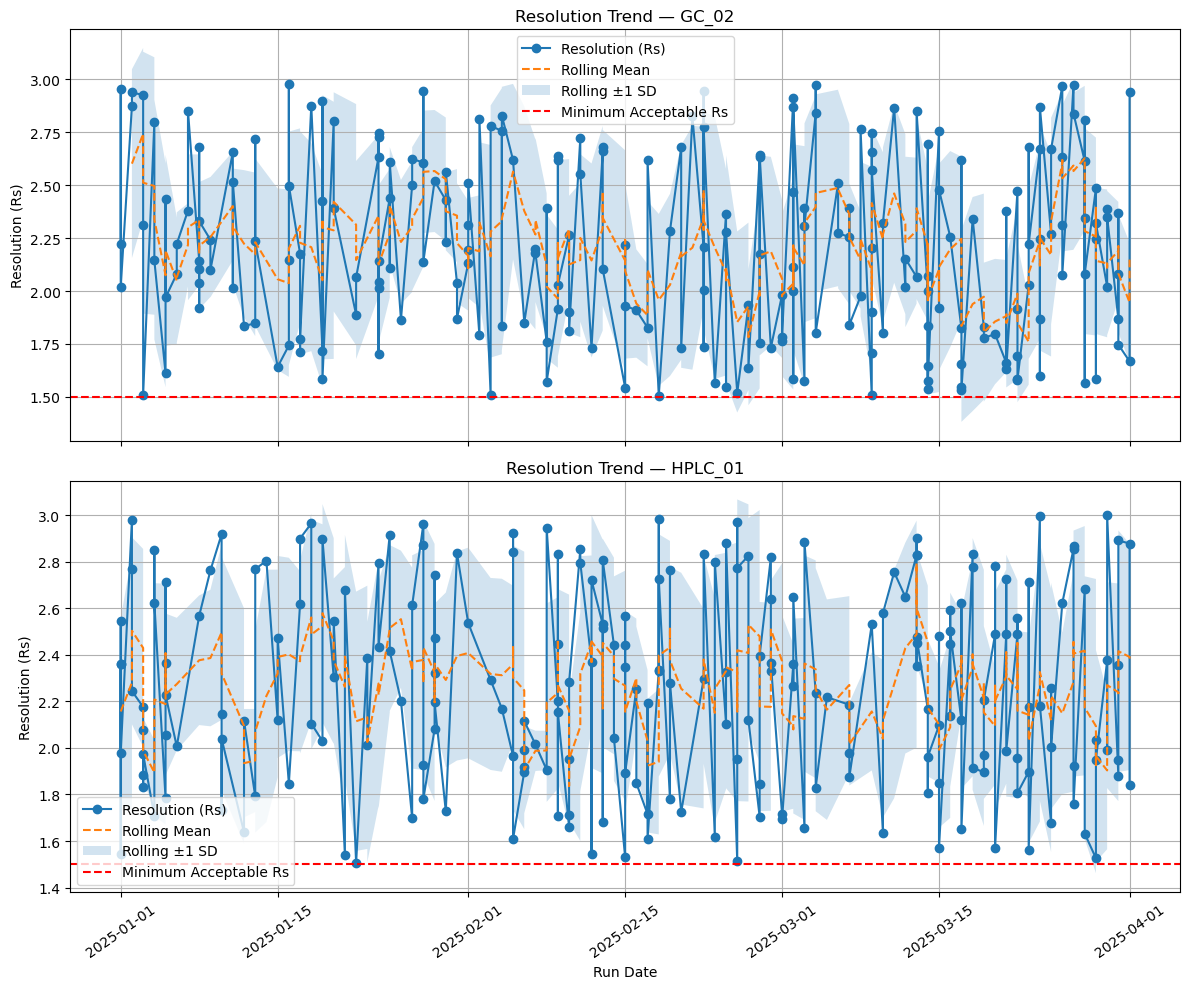

In [9]:
# ========================== FIGURE 1: RESOLUTION TREND CHART ==========================
fig, axes = plt.subplots(len(instrs), 1, figsize=(12, 5 * len(instrs)), sharex=True)
if len(instrs) == 1:
    axes = [axes]

for ax, inst in zip(axes, instrs):
    d = df[df["instrument_id"] == inst].copy()
    d["roll_mean"] = d["resolution"].rolling(5).mean()
    d["roll_sd"] = d["resolution"].rolling(5).std()

    ax.plot(d["run_date"], d["resolution"], marker="o", label="Resolution (Rs)")
    ax.plot(d["run_date"], d["roll_mean"], linestyle="--", label="Rolling Mean")
    ax.fill_between(
        d["run_date"],
        d["roll_mean"] - d["roll_sd"],
        d["roll_mean"] + d["roll_sd"],
        alpha=0.2,
        label="Rolling ±1 SD"
    )
    ax.axhline(1.5, color="red", linestyle="--", label="Minimum Acceptable Rs")
    ax.set_title(f"Resolution Trend — {inst}")
    ax.set_ylabel("Resolution (Rs)")
    ax.grid(True)
    ax.legend()

plt.xlabel("Run Date")
plt.xticks(rotation=35)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/figure_1_resolution_trend.png", dpi=300)
plt.show()

### Instrument Capability Index (Cpk)
Capability indices quantify how well each instrument operates within predefined
system suitability limits. Cpk values ≥1.33 indicate statistically capable and
well-centered performance, while lower values signal increased risk of QC
failures and reduced operational robustness.


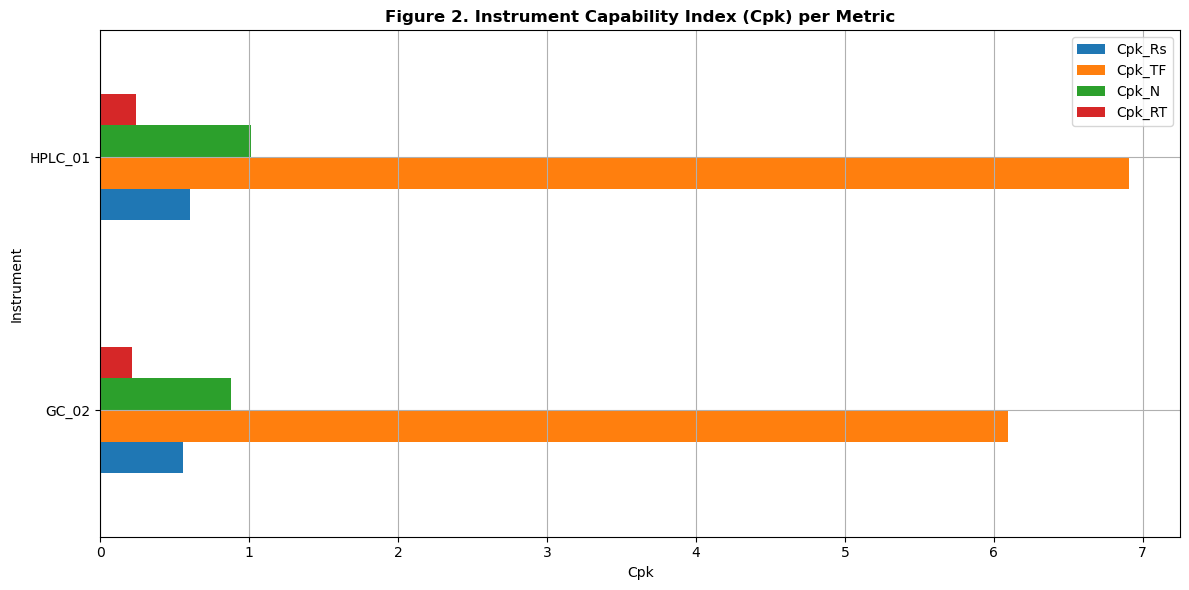

In [14]:
# =================== FIGURE 2: INSTRUMENT CAPABILITY INDEX (CPK) =====================
def compute_cpk(series, LSL, USL):
    sigma = series.std()
    if sigma == 0 or np.isnan(sigma):return np.nan
    mean = series.mean()
    return min((mean - LSL) / (3*sigma), (USL - mean) / (3*sigma))

results = []
for inst in instrs:
    d = df[df["instrument_id"] == inst]
    results.append([inst,
        compute_cpk(d["resolution"], 1.5, 10),
        compute_cpk(d["tailing"], 0, 2),
        compute_cpk(d["plates"], 2000, 1e9),
        compute_cpk(d["retention_time_min"],
                    d["retention_time_min"].mean()*0.98,
                    d["retention_time_min"].mean()*1.02)
    ])

cpk_df = pd.DataFrame(
    results, columns=["Instrument", "Cpk_Rs", "Cpk_TF", "Cpk_N", "Cpk_RT"]).set_index("Instrument")

cpk_df.plot(kind="barh", figsize=(12,6))
plt.title("Figure 2. Instrument Capability Index (Cpk) per Metric", weight="bold")
plt.xlabel("Cpk")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/figure_2_cpk.png", dpi=300)
plt.show()

### Plate Count Change Detection
Theoretical plate counts reflect column efficiency and system dispersion. Z-score
change detection using a 3σ rule enables objective identification of abrupt
efficiency losses often associated with column fouling, void formation, or flow
instability.


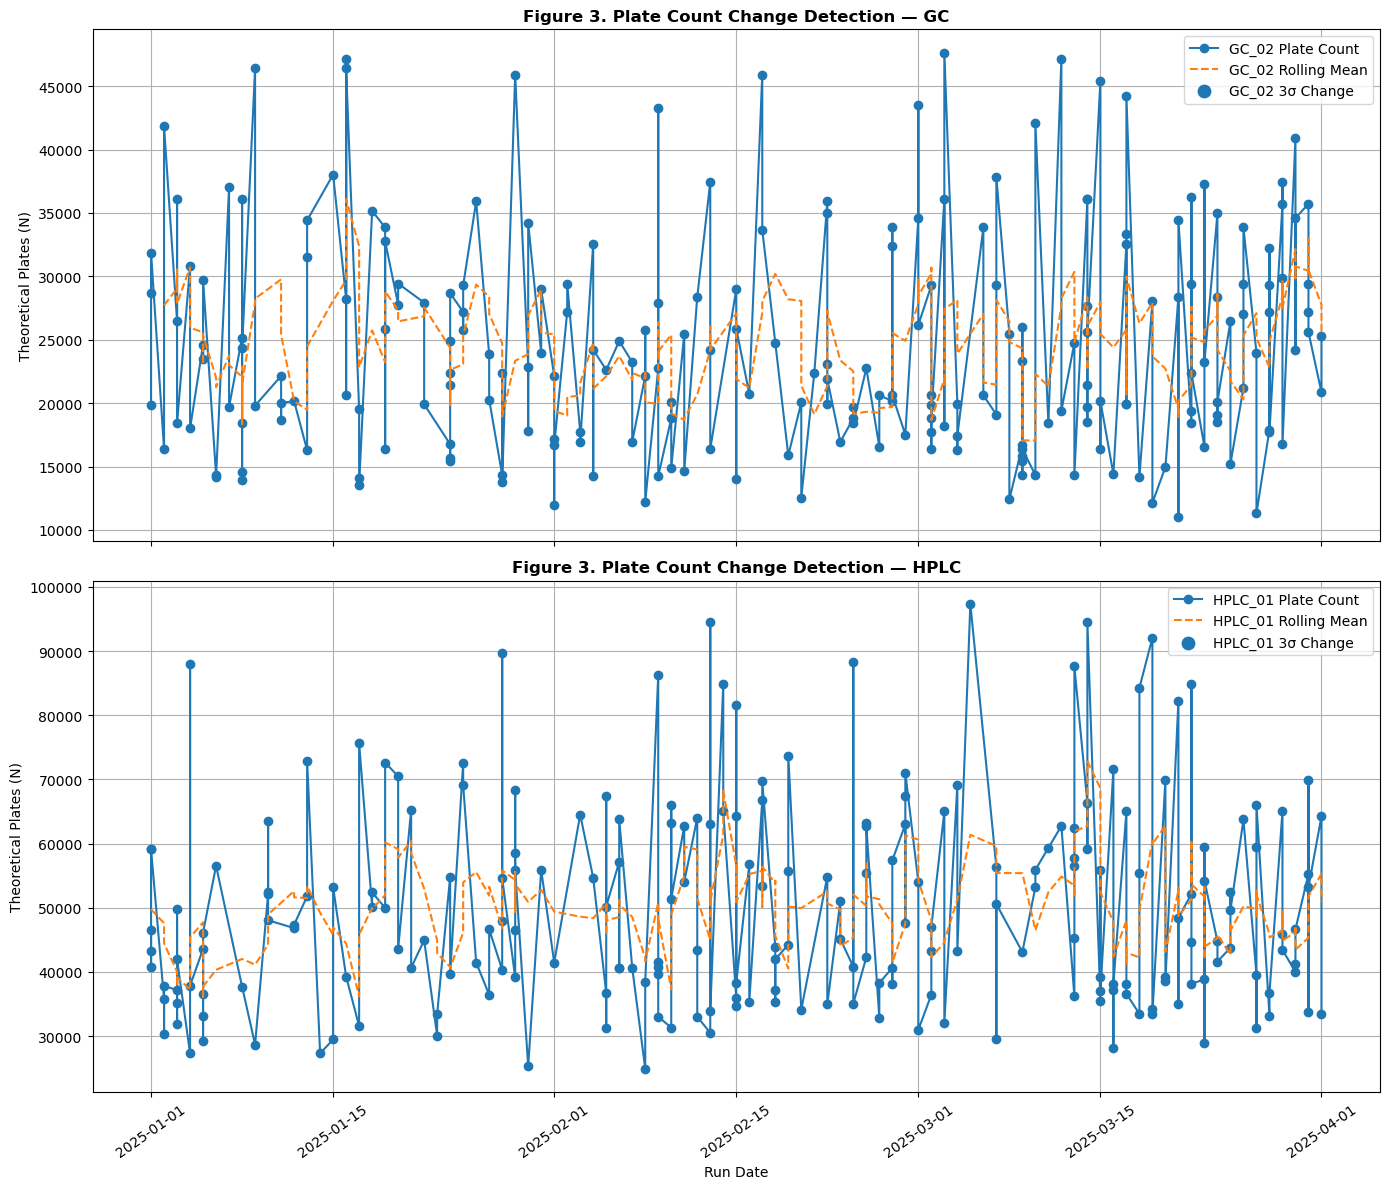

In [4]:
# ========================== FIGURE 3: PLATE COUNT CHANGE DETECTION ==========================

# Classify technique from instrument_id
df["technique"] = df["instrument_id"].str.upper().apply(
    lambda x: "GC" if "GC" in x else ("HPLC" if "HPLC" in x else "OTHER")
)

df_plot = df[df["technique"].isin(["GC", "HPLC"])].copy()
techniques = ["GC", "HPLC"]

fig, axes = plt.subplots(
    nrows=len(techniques),
    ncols=1,
    figsize=(14, 6 * len(techniques)),
    sharex=True)

if len(techniques) == 1:
    axes = [axes]

for ax, tech in zip(axes, techniques):
    dtech = df_plot[df_plot["technique"] == tech]

    for inst in dtech["instrument_id"].unique():
        d = dtech[dtech["instrument_id"] == inst].sort_values("run_date").copy()

        d["roll_mean"] = d["plates"].rolling(5).mean()
        d["roll_std"] = d["plates"].rolling(5).std()
        d["z_score"] = (d["plates"] - d["roll_mean"]) / d["roll_std"]

        ax.plot(
            d["run_date"],
            d["plates"],
            marker="o",
            label=f"{inst} Plate Count")

        ax.plot(
            d["run_date"],
            d["roll_mean"],
            linestyle="--",
            label=f"{inst} Rolling Mean")

        cp = d[abs(d["z_score"]) > 3]
        ax.scatter(cp["run_date"], cp["plates"], s=80, label=f"{inst} 3σ Change")

    ax.set_title(f"Figure 3. Plate Count Change Detection — {tech}", weight="bold")
    ax.set_ylabel("Theoretical Plates (N)")
    ax.grid(True)
    ax.legend()

plt.xlabel("Run Date")
plt.xticks(rotation=35)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/figure_3_plate_change.png", dpi=300)
plt.show()


### System Suitability Heatmap
Monthly pass/fail heatmaps provide a high-level operational overview across
instruments and time. This visualization enables rapid identification of chronic
non-compliance, seasonal effects, or instrument-specific instability.


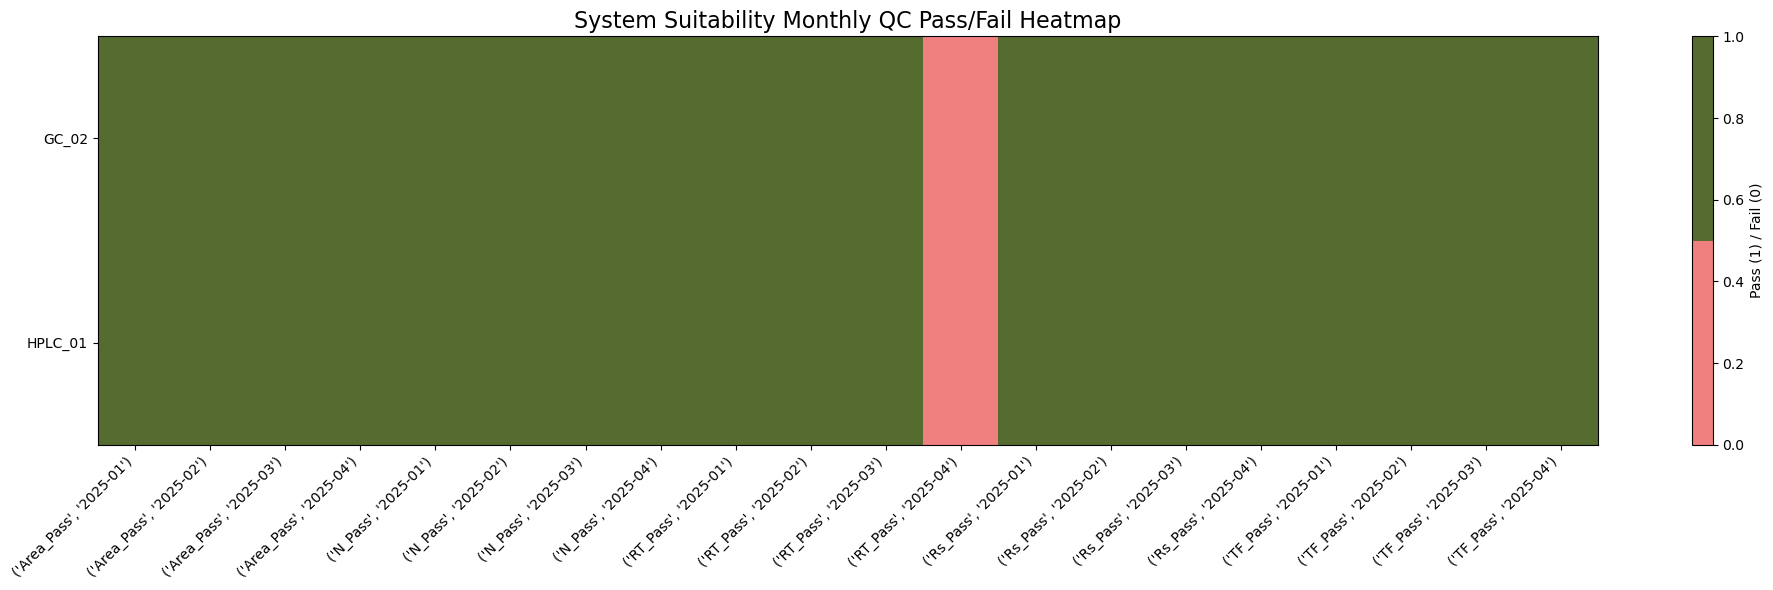

In [18]:
# ========================== FIGURE 4: SYSTEM SUITABILITY HEATMAP ==========================
df['period'] = df['run_date'].dt.to_period("M").astype(str)

# Keep system suitability columns only
ss_cols = ['resolution', 'tailing', 'plates', 'retention_time_min', 'peak_area']

# Average by instrument x period
monthly = df.groupby(['instrument_id', 'period']).agg({
    'resolution': 'mean', 'tailing': 'mean', 'plates': 'mean','retention_time_min': 'mean', 
    'peak_area': 'mean', 'lcl': 'mean',  'ucl': 'mean'}).reset_index()

# Computing pass/fail metrics
monthly['Rs_Pass'] = (monthly['resolution'] >= 1.5).astype(int)
monthly['TF_Pass'] = (monthly['tailing'] <= 2).astype(int)
monthly['N_Pass']  = (monthly['plates'] >= 2000).astype(int)

# Referencing RT per instrument
rt_ref = (monthly.groupby("instrument_id")["retention_time_min"]
    .mean()
    .rename("RTref")
    .reset_index())
monthly = monthly.merge(rt_ref, on="instrument_id", how="left")
monthly["RT_Pass"] = (
    (monthly["retention_time_min"] >= monthly["RTref"] * 0.98) &
    (monthly["retention_time_min"] <= monthly["RTref"] * 1.02)
).astype(int)
monthly["Area_Pass"] = (
    (monthly["peak_area"] >= monthly["lcl"]) &
    (monthly["peak_area"] <= monthly["ucl"])
).astype(int)
metrics = ["Rs_Pass", "TF_Pass", "N_Pass", "RT_Pass", "Area_Pass"]

# Pivot for heatmap (periods on x-axis)
heatmap_df = monthly.pivot_table(index="instrument_id", columns="period", values=metrics)

# Plot heatmap
cmap = ListedColormap(["lightcoral", "darkolivegreen"])
plt.figure(figsize=(20, 6))
plt.imshow(heatmap_df, aspect='auto', cmap=cmap)
plt.xticks(range(len(heatmap_df.columns)), heatmap_df.columns, rotation=45, ha='right')
plt.yticks(range(len(heatmap_df.index)), heatmap_df.index)
plt.colorbar(label="Pass (1) / Fail (0)")
plt.title("System Suitability Monthly QC Pass/Fail Heatmap", fontsize=16)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/figure_4_suitability_heatmap.png", dpi=300)
plt.show()


### Tailing Factor Trends
Tailing factor trends were evaluated to assess peak symmetry, which directly
affects integration accuracy and precision. Values exceeding TF > 2 indicate
potential column chemistry issues, injector contamination, or mobile phase
incompatibility.


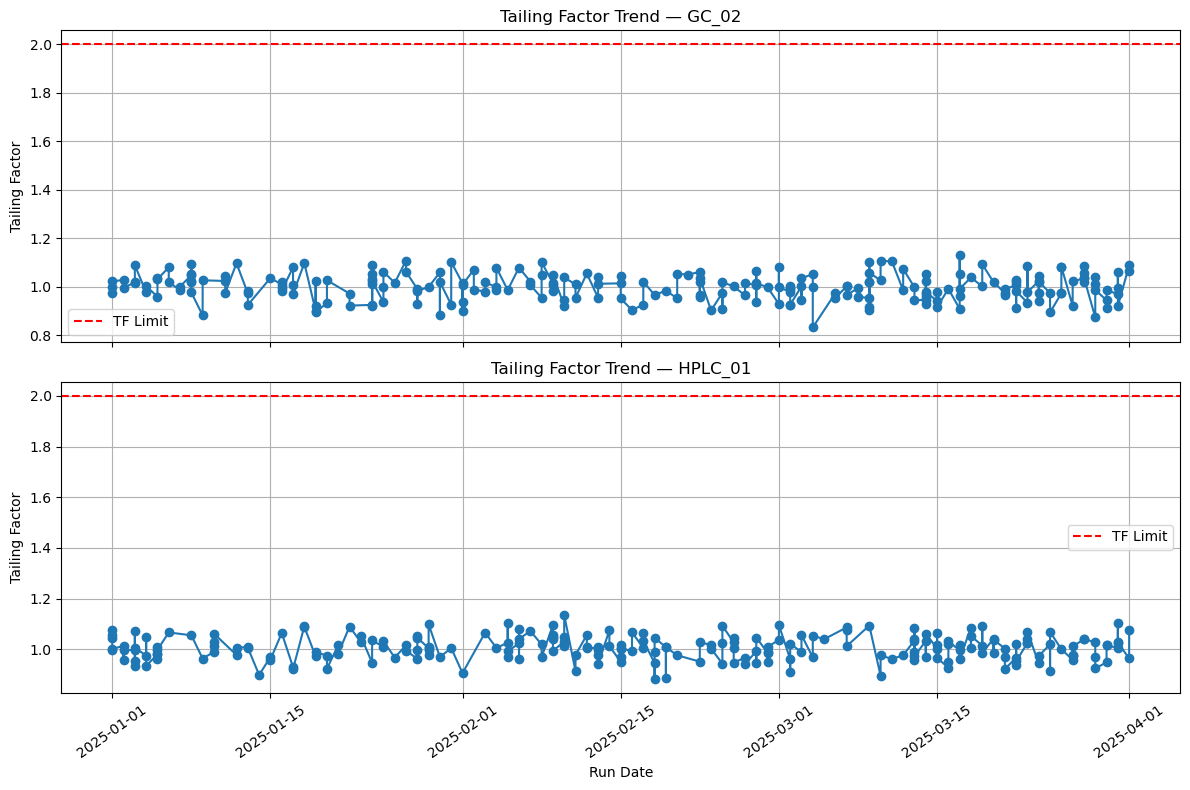

In [20]:
# ========================== FIGURE 5: TAILING FACTOR TREND ==========================
fig, axes = plt.subplots(len(instrs), 1, figsize=(12, 4 * len(instrs)), sharex=True)
if len(instrs) == 1:
    axes = [axes]

for ax, inst in zip(axes, instrs):
    d = df[df["instrument_id"] == inst]
    ax.plot(d["run_date"], d["tailing"], marker="o")
    ax.axhline(2, color="red", linestyle="--", label="TF Limit")
    ax.set_title(f"Tailing Factor Trend — {inst}")
    ax.set_ylabel("Tailing Factor")
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel("Run Date")
axes[-1].xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=35)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/figure_5_tailing_trend.png", dpi=300)
plt.show()


In [22]:
# ========================== TABLE 4: SYSTEM SUITABILITY SUMMARY ==========================
summary = monthly.groupby("instrument_id").agg(
    Rs_Pass_Rate=("Rs_Pass","mean"),
    TF_Pass_Rate=("TF_Pass","mean"),
    N_Pass_Rate=("N_Pass","mean")
).reset_index()

summary.to_csv(f"{TABLE_DIR}/table_4_system_suitability_summary.csv", index=False)
summary


,instrument_id,Rs_Pass_Rate,TF_Pass_Rate,N_Pass_Rate
0,GC_02,1.0,1.0,1.0
1,HPLC_01,1.0,1.0,1.0


### Results and Discussion

Resolution, tailing, and efficiency metrics demonstrated generally stable
performance across instruments, with isolated deviations detected through trend
and change-point analyses. Capability indices supported acceptable operational
control for most metrics, while monthly heatmaps highlighted periods requiring
increased scrutiny.

Collectively, these results confirm system suitability for routine analysis while
providing objective evidence to support targeted maintenance and preventative
intervention strategies.


### QC Conclusions and Instrument Fitness

Instruments meeting resolution, tailing, efficiency, and capability thresholds
were deemed fit for continued analytical use. Instruments exhibiting repeated
plate-count change points or marginal Cpk values should be prioritized for
diagnostic review, maintenance, or requalification.


In [23]:
# ========================== REPRODUCIBILITY METADATA ==========================
print("Report generated:", datetime.now())
print("Python:", sys.version.split()[0])
print("Pandas:", pd.__version__)


Report generated: 2025-12-26 08:12:44.045077
Python: 3.12.5
Pandas: 2.2.2
